# Predict rain days for specified region, given 8 upper atm variables

This notebook calculates rain on a 128x128 grid given 8 upper atm variables, via a CNN pre-trained model.


### TODO items

* better graphs
* load netcdf files directly (currently loads numpy files)



In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# define internal pic res
ires = 16
res = 128
nvars = 8
mnvars = 8*1 +1


In [3]:

class GenerativeNet(torch.nn.Module):

    def __init__(self):
        super(GenerativeNet, self).__init__()

        self.conv11 = nn.Sequential(
            #nn.BatchNorm2d(mnvars),
            nn.Conv2d(
                in_channels=mnvars, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv22 = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=2048, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2048, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024+1024*1, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512+mnvars*1, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=nvars, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            #nn.BatchNorm2d(nvars),
            #nn.LeakyReLU(0.2, inplace=True)
            nn.Sigmoid() # constrain output to 0-1 b/c SSIM does not like them
        )
        # NOT USED # smoothing 3x3 stride 1 conv
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=nvars, out_channels=nvars, kernel_size=3,
                stride=1, padding=1, bias=True
            ),
            #nn.BatchNorm2d(nvars),
            #nn.LeakyReLU(0.2, inplace=True)
            nn.Sigmoid() # constrain output to 0-1 b/c SSIM does not like them
        )

    def forward(self, x):
        # Project and reshape
        #x = self.linear(x)
        x1 = x.view(x.shape[0], mnvars, ires, ires)

        #m = nn.Dropout(p=0.1)
        #x1 = m(x1)

        # Convolutional layers
        x2 = self.conv11(x1)
        x = self.conv22(x2)
        #x = self.conv333(x)

        x = self.conv1(x)

        x = self.conv2(torch.cat((x, x2), dim=1))
        x = self.conv3(torch.cat((x, x1), dim=1))
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x



In [4]:
# load generator
generator = GenerativeNet()
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/uatm-erai-with-doy-cuda_generator-e850", map_location=torch.device('cuda:0'))
gstate = torch.load("/glade/scratch/dkorytin/saved_models/uatm-erai-with-doy-cuda_generator-e850", map_location=torch.device('cpu'))
minmaxo = gstate['minmaxo']
minmaxi = gstate['minmaxi']
generator.load_state_dict(gstate['generator'])
generator.eval()


GenerativeNet(
  (conv11): Sequential(
    (0): Conv2d(9, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv22): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv1): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(2048, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative

# Load output gridmet data (to verify agaist if wanted)

In [5]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 



nvars = 8
mb = 4      # minibatch size

# load files
d = np.load('/glade/work/dkorytin/srgan_data/prec128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv2 = np.load('/glade/work/dkorytin/srgan_data/tmax128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv3 = np.load('/glade/work/dkorytin/srgan_data/tmin128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv4 = np.load('/glade/work/dkorytin/srgan_data/uas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv5 = np.load('/glade/work/dkorytin/srgan_data/vas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv6 = np.load('/glade/work/dkorytin/srgan_data/huss128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv7 = np.load('/glade/work/dkorytin/srgan_data/rsds128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv8 = np.load('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.npy')[istart:istart+ndays]

[[v1min,v1max],[v2min,v2max],[v3min,v3max],[v4min,v4max],[v5min,v5max],[v6min,v6max],[v7min,v7max],[v8min,v8max]] = minmaxo # saved w/ model
## Find min/max for each variable
#v1max = minmaxo[0][1]; v1min = minmaxo[0][0]
#v2max = minmaxo[1][1]; v2min = minmaxo[1][0]
#v3max = minmaxo[2][1]; v3min = minmaxo[2][0]
#v4max = minmaxo[3][1]; v4min = minmaxo[3][0]
#v5max = minmaxo[4][1]; v5min = minmaxo[4][0]
#v6max = minmaxo[5][1]; v6min = minmaxo[5][0]
#v7max = minmaxo[6][1]; v7min = minmaxo[6][0]
#v8max = minmaxo[7][1]; v8min = minmaxo[7][0]
print("v1 max/min", v1max, v1min)
print("v2 max/min", v2max, v2min)
print("v3 max/min", v3max, v3min)
print("v4 max/min", v4max, v4min)
print("v5 max/min", v5max, v5min)
print("v6 max/min", v6max, v6min)
print("v7 max/min", v7max, v7min)
print("v8 max/min", v8max, v8min)
print("minmaxo", minmaxo)


# normalize each var to 0-1
d = d**0.25/(v1max)
dv2 = (dv2-v2min)/(v2max-v2min)
dv3 = (dv3-v3min)/(v3max-v3min)
dv4 = (dv4-v4min)/(v4max-v4min)
dv5 = (dv5-v5min)/(v5max-v5min)
dv6 = (dv6-v6min)/(v6max-v6min)
dv7 = (dv7-v7min)/(v7max-v7min)
dv8 = (dv8-v8min)/(v8max-v8min)

# mask & mask_bias
#mask = 1-torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
#invmask = torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
mask = 1-torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
invmask = torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
b1 = invmask*(0-v1min)/(v1max-v1min)
b2 = invmask*(0-v2min)/(v2max-v2min)
b3 = invmask*(0-v3min)/(v3max-v3min)
b4 = invmask*(0-v4min)/(v4max-v4min)
b5 = invmask*(0-v5min)/(v5max-v5min)
b6 = invmask*(0-v6min)/(v6max-v6min)
b7 = invmask*(0-v7min)/(v7max-v7min)
b8 = mask*(0-v8min)/(v8max-v8min)
mask_bias = torch.cat((b1,b2,b3,b4,b5,b6,b7,b8),1).detach()


v1 max/min 4.087455 0.0
v2 max/min 49.037712 -34.785778
v3 max/min 33.991703 -46.725536
v4 max/min 19.132183 -19.009077
v5 max/min 17.8808 -18.086332
v6 max/min 0.024878306 0.0
v7 max/min 447.97797 0.0
v8 max/min 1.0 0.0
minmaxo [[0.0, 4.087455], [-34.785778, 49.037712], [-46.725536, 33.991703], [-19.009077, 19.132183], [-18.086332, 17.8808], [0.0, 0.024878306], [0.0, 447.97797], [0.0, 1.0]]


# Load input data

In [6]:
###########################
## LOAD ERAI data: daily ##
###########################

# load eraionmpi
#mndays = 11688      # 1979-2010
mstart = 365
mndays = 13515       # 1980-2016 
#mnvars = 8*4
mnvars = 8*1
md = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv2 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv3 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv4 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv5 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv6 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv7 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv8 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]

print("Days loaded", len(mdv7))

[[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max]] = minmaxi # saved w/ model
## Find min/max for each variable
#mv1max = md.max(); mv1min = md.min()
#mv2max = mdv2.max(); mv2min = mdv2.min()
#mv3max = mdv3.max(); mv3min = mdv3.min()
#mv4max = mdv4.max(); mv4min = mdv4.min()
#mv5max = mdv5.max(); mv5min = mdv5.min()
#mv6max = mdv6.max(); mv6min = mdv6.min()
#mv7max = mdv7.max(); mv7min = mdv7.min()
#mv8max = mdv8.max(); mv8min = mdv8.min()
print("mv1 max/min", mv1max, mv1min)
print("mv2 max/min", mv2max, mv2min)
print("mv3 max/min", mv3max, mv3min)
print("mv4 max/min", mv4max, mv4min)
print("mv5 max/min", mv5max, mv5min)
print("mv6 max/min", mv6max, mv6min)
print("mv7 max/min", mv7max, mv7min)
print("mv8 max/min", mv8max, mv8min)

# normalize each var to 0-1
md = (md-mv1min)/(mv1max-mv1min)
mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
mdv8 = (mdv8-mv8min)/(mv8max-mv8min)

mndays = len(mdv8)    #//4
print("mndays", mndays)

# synthetically create 16x16 input samples via bilinear scaling
dd=[]
ddo=[]
for ii in range(mndays):
    # input samples
    rowdd = []
    for iii in [0]: #range(4):
    #for iii in range(4):
       rowdd.append( cv2.resize(md[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv2[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv3[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv4[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv5[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv6[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv7[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv8[ii*1+iii],(16,16)) )
       # add doy
       rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

       dd.append(rowdd)

    # output samples
    rowddo = []
    rowddo.append( d[ii] )
    rowddo.append( dv2[ii] )
    rowddo.append( dv3[ii] )
    rowddo.append( dv4[ii] )
    rowddo.append( dv5[ii] )
    rowddo.append( dv6[ii] )
    rowddo.append( dv7[ii] )
    rowddo.append( dv8[ii] )
    ddo.append(rowddo)
    
# add channel for cos
mnvars = 9

d = np.array(dd)
do = np.array(ddo)
print("d, do, md",d.shape, do.shape, np.array(md).shape)

# input samples
samples = []
print("ndays, mndays", ndays, mndays)
for t in range(ndays):
    samples.append(d[t])
samples = torch.tensor(np.reshape(samples, (ndays, mnvars, ires, ires)))

# output samples
osamples = []    # 20x20 samples
for t in range(ndays):
    osamples.append(do[t])
osamples = torch.tensor(np.reshape(osamples, (ndays, nvars, res, res)))
print("osamples max min",osamples.max(), osamples.min())

# debug
np.save("delme.npy", samples[0,2])
#np.save("delme.npy", mdv3[0])
print("DONEDONE\n\n", mdv3[0][0].shape)

def dn(pr_img):
    #print('OioijIOJ', v1max, v1min, float(pr_img.max()), float(pr_img.min()), pr_img.shape)
    return (pr_img*(v1max-v1min)+v1min)**4
def rn(pr_img):
    #return (pr_img-v1min**4)/(v1max**4-v1min**4)
    #print('OioijIOJ222222', v1max, v1min, float(pr_img.max()), float(pr_img.min()), pr_img.shape)
    #return pr_img/v1max_orig
    return pr_img/v1max**4


Days loaded 13515
mv1 max/min 29.960123 -32.7581
mv2 max/min 30.62581 -32.324654
mv3 max/min 0.017681489 4.8779977e-05
mv4 max/min 294.80206 228.65608
mv5 max/min 3278.9453 2396.74
mv6 max/min 6005.7915 4669.179
mv7 max/min 99.96935 -43.84638
mv8 max/min 75.44277 -83.25877
mndays 13515
d, do, md (13515, 9, 16, 16) (13515, 8, 128, 128) (13515, 18, 18)
ndays, mndays 13515 13515
osamples max min tensor(1.1676) tensor(0.)
DONEDONE

 (18,)


In [7]:
##################################
## convert in batches of 1 #000 ##
##################################
downscaled_imgs = np.zeros((ndays,nvars,res,res))

#input_img = samples[0:1].cuda()
#print("input_img", input_img.shape)
#corrected_img = generator(input_img).data.cpu() 
#print("corrected_img", corrected_img.shape)

mb = 1

xplot = []
yplot = []
ymulti = []
raininput = torch.zeros(9,16,16)
dryinput = torch.zeros(9,16,16)
raincount = 0
drycount = 0
#for ii in range(0,mndays,mb):
for ii in range(0,11688,1):
    doy = ii % 365.25
    #if doy >= 0 and doy <= 30:      # Dec
    if doy >= 120 and doy <= 150:   # May
        #input_img = samples[ii:ii+mb].cuda()
        input_img = samples[ii:ii+mb]
        generated_img = generator(input_img)#.data.cpu()
        generated_img = torch.cat((generated_img[:,0:7,:,:] * mask[:,0:1,:,:].detach(), generated_img[:,7:8,:,:]*invmask[:,0:1,:,:].detach()), 1) + mask_bias

        #mpr = dn(generated_img[:,0,:,:]).mean()
        mpr = dn(generated_img[:,0,35:60,42:75]).mean()
        print ("day, doy, mpr (mm/day)", ii, doy, mpr)
        if mpr > 1:
            raininput += samples[ii,:,:,:]
            raincount += 1
        if mpr < .3:
            dryinput += samples[ii,:,:,:]
            drycount += 1

        #print("generated_img", generated_img.shape)
        downscaled_imgs[ii:ii+mb] = generated_img[0:mb].data.cpu()
        #print("corrected_img", downscaled_imgs.shape)

raininput /= raincount
dryinput /= drycount


day, doy, mpr (mm/day) 120 120.0 tensor(3.7198, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 121 121.0 tensor(5.8660, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 122 122.0 tensor(4.7142, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 123 123.0 tensor(0.3968, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 124 124.0 tensor(0.3576, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 125 125.0 tensor(1.0142, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 126 126.0 tensor(1.6969, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 127 127.0 tensor(3.3174, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 128 128.0 tensor(2.4429, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 129 129.0 tensor(0.1386, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 130 130.0 tensor(0.0805, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 131 131.0 tensor(3.2431, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 132 132.0 tensor(3.6693, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 133 133.0 tensor(0.9276, gra

day, doy, mpr (mm/day) 1236 140.25 tensor(10.7749, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1237 141.25 tensor(1.1823, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1238 142.25 tensor(2.9581, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1239 143.25 tensor(1.7747, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1240 144.25 tensor(2.7371, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1241 145.25 tensor(2.0327, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1242 146.25 tensor(3.0671, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1243 147.25 tensor(4.0007, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1244 148.25 tensor(3.9539, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1245 149.25 tensor(8.7577, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1581 120.0 tensor(0.5093, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1582 121.0 tensor(6.9574, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1583 122.0 tensor(9.2900, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 1584

day, doy, mpr (mm/day) 2686 129.25 tensor(0.2604, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2687 130.25 tensor(0.9875, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2688 131.25 tensor(1.2332, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2689 132.25 tensor(0.6875, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2690 133.25 tensor(3.0843, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2691 134.25 tensor(3.0365, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2692 135.25 tensor(1.7001, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2693 136.25 tensor(0.8030, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2694 137.25 tensor(2.2360, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2695 138.25 tensor(5.0445, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2696 139.25 tensor(1.6286, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2697 140.25 tensor(2.8749, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2698 141.25 tensor(16.8522, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 2

day, doy, mpr (mm/day) 3802 149.5 tensor(11.3771, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4138 120.25 tensor(2.1500, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4139 121.25 tensor(11.1162, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4140 122.25 tensor(12.5759, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4141 123.25 tensor(6.3796, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4142 124.25 tensor(0.7400, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4143 125.25 tensor(0.5033, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4144 126.25 tensor(4.2158, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4145 127.25 tensor(7.9227, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4146 128.25 tensor(0.6139, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4147 129.25 tensor(0.3769, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4148 130.25 tensor(1.0351, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 4149 131.25 tensor(1.2600, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 

day, doy, mpr (mm/day) 5252 138.5 tensor(0.0067, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5253 139.5 tensor(9.7131e-06, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5254 140.5 tensor(0.0959, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5255 141.5 tensor(0.6144, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5256 142.5 tensor(1.9056, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5257 143.5 tensor(3.4299, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5258 144.5 tensor(13.2368, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5259 145.5 tensor(8.2330, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5260 146.5 tensor(3.3870, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5261 147.5 tensor(2.7852, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5262 148.5 tensor(10.3295, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5263 149.5 tensor(0.2623, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5599 120.25 tensor(4.0892, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 5600 121

day, doy, mpr (mm/day) 6702 127.5 tensor(5.7538, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6703 128.5 tensor(9.0074, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6704 129.5 tensor(0.0347, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6705 130.5 tensor(0.0799, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6706 131.5 tensor(0.0441, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6707 132.5 tensor(0.1320, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6708 133.5 tensor(0.4682, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6709 134.5 tensor(3.2094, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6710 135.5 tensor(0.0157, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6711 136.5 tensor(0.0945, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6712 137.5 tensor(0.3556, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6713 138.5 tensor(0.0541, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6714 139.5 tensor(0.0312, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 6715 140.5 tens

day, doy, mpr (mm/day) 7818 147.75 tensor(5.1212, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 7819 148.75 tensor(15.7848, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 7820 149.75 tensor(11.1708, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8156 120.5 tensor(0.1687, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8157 121.5 tensor(0.1916, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8158 122.5 tensor(3.5581, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8159 123.5 tensor(0.9566, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8160 124.5 tensor(4.9013, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8161 125.5 tensor(0.9227, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8162 126.5 tensor(7.7776, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8163 127.5 tensor(5.2648, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8164 128.5 tensor(3.3208, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8165 129.5 tensor(4.1069, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 8166 130.5

day, doy, mpr (mm/day) 9268 136.75 tensor(0.0019, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9269 137.75 tensor(0.2239, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9270 138.75 tensor(1.2749, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9271 139.75 tensor(2.5487e-06, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9272 140.75 tensor(0.0239, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9273 141.75 tensor(0.6910, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9274 142.75 tensor(3.8234, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9275 143.75 tensor(6.3921, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9276 144.75 tensor(3.1671, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9277 145.75 tensor(3.6177, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9278 146.75 tensor(1.2903, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9279 147.75 tensor(6.1872, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 9280 148.75 tensor(2.1904, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day

day, doy, mpr (mm/day) 10719 126.75 tensor(0.3196, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10720 127.75 tensor(7.9951, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10721 128.75 tensor(3.5144, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10722 129.75 tensor(5.7708, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10723 130.75 tensor(8.0267, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10724 131.75 tensor(4.8584, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10725 132.75 tensor(3.7947, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10726 133.75 tensor(4.5938, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10727 134.75 tensor(6.1430, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10728 135.75 tensor(7.5062, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10729 136.75 tensor(0.1322, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10730 137.75 tensor(1.3519e-14, grad_fn=<MeanBackward0>)
day, doy, mpr (mm/day) 10731 138.75 tensor(1.8671e-12, grad_fn=<MeanBackward0>)
day,

# Plots

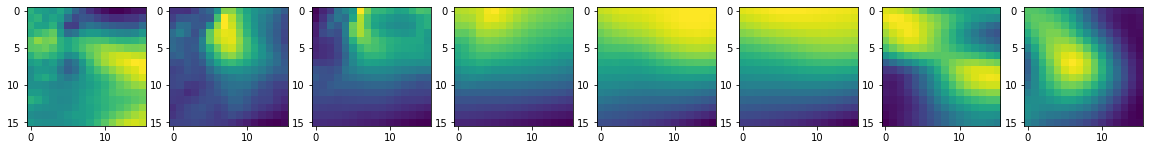

In [8]:
# plot average rain inputs
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    axarr[ii].imshow(raininput[ii])

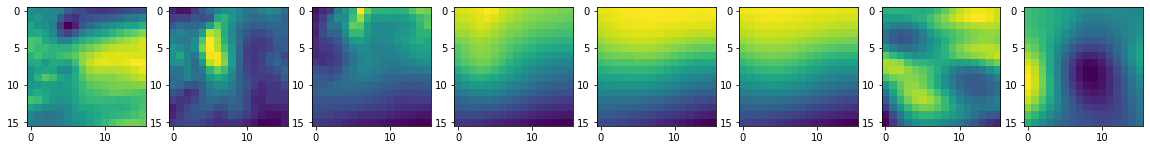

In [9]:
# plot average dry inputs
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    axarr[ii].imshow(dryinput[ii])

In [10]:
# what about the cos() channel
print(raininput[8].mean(), dryinput[8].mean())

tensor(0.1593) tensor(0.1664)
